<a href="https://colab.research.google.com/github/KillingVectorField/latent-sequence-model-EM-algorithm/blob/main/Assignment_1_EM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment 1 Part 3**

Zhixuan Shao 917804098

Yuxuan Zhang 916653596

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle

# Utility function for reading in data from course Box folder

In [ ]:
import io
import requests
from tqdm import tqdm

from sklearn.preprocessing import OneHotEncoder

#----------------------------------------
#from Chenxi Liu
#function for downloading sequence data from Box and converting to one-hot encoding
#note this function actually returns the summary statistics over the data, which is
#just the total number of each bases across all input sequences for our simple 
#latent variable model.
#

def get_sequence(url, categories=['A', 'C', 'G', 'T']):
  '''
  this function by default returns a summary of all data.
  '''
  r = requests.get(url)
  df = pd.read_csv(io.StringIO(r.text), sep=" ", header=None)
  s1 = np.array(list(str(df.to_numpy()[0, :][0])), dtype=object).reshape(-1, 1)

  m = len(df)
  sequence_len = len(list(df.iloc[0, :].values)[0])
  data = np.zeros((m, sequence_len, len(categories)))
  data_ss = np.zeros((1, len(categories)))

  ohe = OneHotEncoder(sparse=False, categories=[np.array(categories, dtype=object)])
  example_sequence = np.array(list(str(df.to_numpy()[0, :][0])), dtype=object).reshape(-1, 1)

  ohe.fit(s1)

  for ii in tqdm(range(m)):
    
    s = list(str(df.to_numpy()[ii, :][0]))
    s_a = np.array(s).reshape(-1, 1)
    data[ii, :, :] = ohe.transform(s_a)
  
  for ii in range(len(categories)):
    data_ss[0,ii] = np.sum(data[:,:,ii])

  return data, data_ss


def get_sequence_traintest(url, categories=['A', 'C', 'G', 'T'], FRACTION_TRAINING=0.8):
  r = requests.get(url)
  df = pd.read_csv(io.StringIO(r.text), sep=" ", header=None)
  s1 = np.array(list(str(df.to_numpy()[0, :][0])), dtype=object).reshape(-1, 1)

  m = len(df)
  sequence_len = len(list(df.iloc[0, :].values)[0])
  data = np.zeros((m, sequence_len, len(categories)))
  data_ss_train = np.zeros((1, len(categories)))
  data_ss_test = np.zeros((1, len(categories)))

  ohe = OneHotEncoder(sparse=False, categories=[np.array(categories, dtype=object)])
  example_sequence = np.array(list(str(df.to_numpy()[0, :][0])), dtype=object).reshape(-1, 1)

  ohe.fit(s1)

  for ii in tqdm(range(m)):
    
    s = list(str(df.to_numpy()[ii, :][0]))
    s_a = np.array(s).reshape(-1, 1)
    data[ii, :, :] = ohe.transform(s_a)


   #randomly permute rows of matrix
  np.random.shuffle(data)

  train_indices = np.arange(start=0,stop=round(FRACTION_TRAINING*data.shape[0]))
  test_indices = np.arange(start=round(FRACTION_TRAINING*data.shape[0]), stop=data.shape[0])
  
  for ii in range(len(categories)):
    data_ss_train[0,ii] = np.sum(data[train_indices,:,ii])
    data_ss_test[0,ii] = np.sum(data[test_indices,:,ii])

  return data_ss_train, data_ss_test

In [ ]:
XXss_sequences_padded, XX_sequences_padded = get_sequence('https://ucdavis.box.com/shared/static/0cacx2xvn4ugxo9h21ci2ngesryigf43.txt')

100%|██████████| 357/357 [00:00<00:00, 2834.10it/s]


In [ ]:
N, L = XXss_sequences_padded.shape[:2]
P = 18

In [ ]:
N, L, P

(357, 38, 18)

# Core EM code

In [ ]:
#----------------------------------------
# parameter initialization
# psi_0: a 4 * P matrix of background psi parameters
# psi_1: a 4 * P matrix of foreground psi parameters
# lmbda: an array of length L-P+1

def init_EM(seed=0, L=L, P=P):
  np.random.seed(seed=seed)
  lmbda = np.random.uniform(0, 1,size=(L-P+1,))
  lmbda /= lmbda.sum()
  psi_0 = np.random.uniform(0,1,size=(4,P))
  psi_0 /= psi_0.sum(axis=0)
  psi_1 = np.random.uniform(0,1,size=(4,P))
  psi_1 /= psi_1.sum(axis=0)
  theta = {'lmbda': lmbda, 'psi_0': psi_0, 'psi_1': psi_1}
  return(theta)

def E_step(theta, X, P=P):
  '''
  X is N*L*4
  Returns the N*(L-P+1) matrix E_q[C_{i,j}]
  '''
  # unnormalized_posteriors = theta['psi']*theta['lmbda']
  # normalized_posteriors = (unnormalized_posteriors.T/unnormalized_posteriors.sum(axis=1)).T
  # return(normalized_posteriors)
  N, L = X.shape[:2]
  EqC = np.zeros((N, L-P+1))
  lmbda = theta['lmbda']
  psi_ratio = theta['psi_1']/theta['psi_0']
  for i in range(len(X)):
    for j in range(L-P+1):
      Xij = X[i,j:(j+P)] # P*4
      EqC[i,j] = lmbda[j]* (Xij.T * psi_ratio).sum(axis=0).prod()
  return (EqC.T/EqC.sum(axis=1)).T

def M_step(X, EqC, P=P):
  '''
  compute MLE of psi, lambda
  return a dictionary containing psi, lambda
  X is N*L*4
  EqC is N*(L-P+1)
  '''
  N, L = X.shape[:2]
  lmbda = EqC.mean(axis=0)
  lmbda /= lmbda.sum()
  psi_1 = np.zeros((4,P))
  psi_0 = np.zeros((4,P))
  for i in range(N):
    for j in range(L-P+1):
      Xij = X[i,j:(j+P)].T # 4*P
      psi_1 += EqC[i,j] * Xij
      psi_0 += (1-EqC[i,j]) * Xij
  psi_1 /= N
  psi_0 /= N * (L-P)
  return {'lmbda':lmbda, 'psi_0':psi_0, 'psi_1':psi_1}


def loglikelihood(X, theta, EqC, P=P):
  '''
  compute log likelihood, given posteriors based off the current parameter set theta (so KL = 0)
  '''
  N,L = X.shape[:2]
  part_1 = EqC * np.log(theta['lmbda'])
  part_1[np.where(EqC == 0)] = 0
  part_1 = part_1.sum()
  part_2 = 0
  for i in range(N):
    for j in range(L-P+1):
      Xij = X[i,j:(j+P)].T # 4 * P
      if EqC[i,j]>0:
        weighted_X = Xij*np.log(theta['psi_1'])
        weighted_X[np.where(Xij==0)] = 0
        part_2 += EqC[i,j]*(weighted_X).sum()
      if EqC[i,j]<1:
        weighted_X = Xij*np.log(theta['psi_0'])
        weighted_X[np.where(Xij==0)] = 0
        part_2 += (1-EqC[i,j]) * (weighted_X).sum()
  expected_complete_LL = part_1 + part_2
  
  #entropy term calculation needs to be careful since 0log0 = 0, but coded naively will give nan
  qlogq = EqC * np.log(EqC);
  qlogq[np.where(EqC == 0)] = 0 #0log0 = 0
  entropy = - qlogq.sum()
  return (expected_complete_LL + entropy) #log likelihood = ELBO + entropy, when q=p
    

In [ ]:
theta = init_EM()

In [ ]:
EqC = E_step(theta,XXss_sequences_padded)

In [ ]:
theta_new = M_step(XXss_sequences_padded, EqC)

loglikelihood after one-step EM

In [ ]:
loglikelihood(XXss_sequences_padded, theta_new, EqC)

-186570.55555502416

# Run EM

In [ ]:
def run_EM(init_theta, X, L=L, P=P, n_iter=20):
  record_loglik = []
  theta = init_theta
  for i in tqdm(range(n_iter)):
    EqC = E_step(theta, X, P)
    record_loglik.append(loglikelihood(X, theta, EqC, P))
    theta = M_step(X, EqC, P)
  return theta, EqC, record_loglik

In [ ]:
theta, EqC, record_loglik = run_EM(init_EM(0), XXss_sequences_padded)

100%|██████████| 20/20 [00:07<00:00,  2.74it/s]


-184109.32319060445


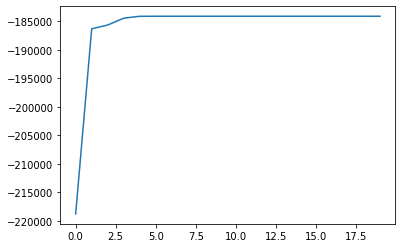

In [ ]:
print(record_loglik[-1])
plt.plot(record_loglik)
plt.show()

In [ ]:
record_loglik

[-218781.87729234816,
 -186311.17158275575,
 -185649.41096204476,
 -184447.6232676424,
 -184116.9610665007,
 -184110.6783507612,
 -184109.43849124177,
 -184109.3626311305,
 -184109.35582075783,
 -184109.35178940307,
 -184109.3479300338,
 -184109.34416985448,
 -184109.34056769664,
 -184109.33718513403,
 -184109.33407261557,
 -184109.33126467315,
 -184109.32877834685,
 -184109.32661421635,
 -184109.32475925516,
 -184109.32319060445]

We verify that the loglikelihood monotonically increases.

In [ ]:
result_list = [run_EM(init_EM(i), XXss_sequences_padded, n_iter=20) for i in range(20,30)]

 45%|████▌     | 9/20 [00:03<00:04,  2.72it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in multiply
 65%|██████▌   | 13/20 [00:04<00:02,  2.74it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in multiply
100%|██████████| 20/20 [00:07<00:00,  2.77it/s]


In [ ]:
#with open('/content/drive/MyDrive/Colab Notebooks/result_list.pickle', 'wb') as f:
with open('result_list.pickle', 'wb') as f:
   pickle.dump(result_list, f)

In [ ]:
#with open('/content/drive/MyDrive/Colab Notebooks/result_list.pickle', 'rb') as f:
with open('result_list.pickle', 'rb') as f:
  result_list = pickle.load(f)

## Check if log likelihood monotonically increases.

-183198.60081663978


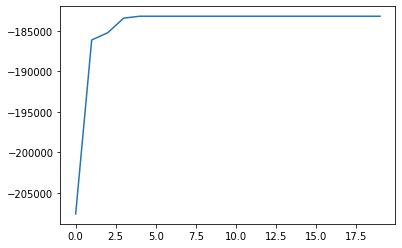

-183261.8895018651


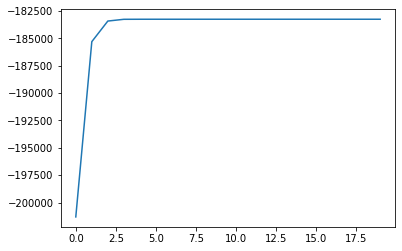

-184538.58635464968


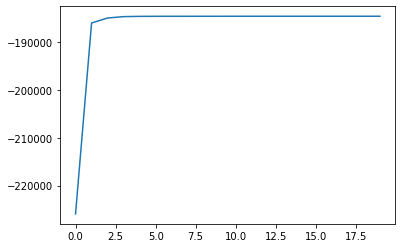

-183261.8895018651


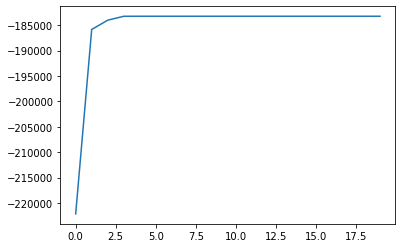

-184109.36103388626


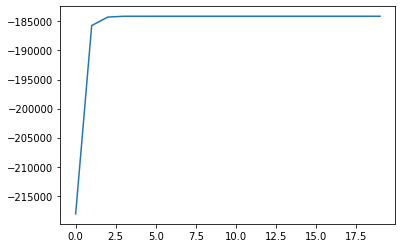

-183630.8354917751


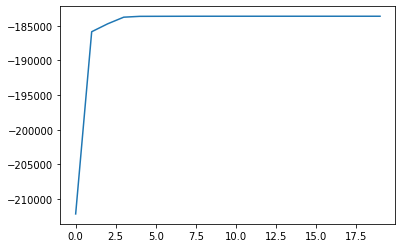

-183357.21547712435


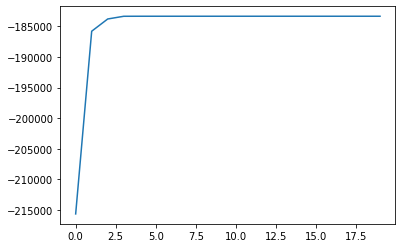

-183249.7663413064


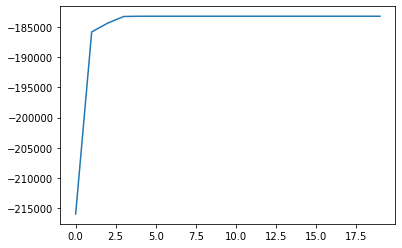

-183262.78749803803


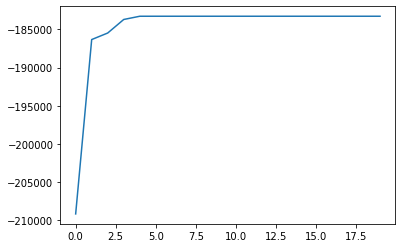

-183262.78461628762


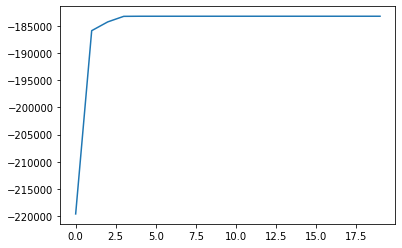

In [ ]:
for iter in result_list:
  print(iter[2][-1])
  plt.plot(iter[2])
  plt.show()

We verify that the loglikelihood monotonically increases under every initialization.

In [ ]:
np.argmax([iter[2][-1] for iter in result_list])

0

In [ ]:
theta, EqC, record_loglik = result_list[np.argmax([iter[2][-1] for iter in result_list])]

# Sequence logo visualization of the foreground motif 

In [ ]:
!pip install logomaker
import logomaker

     |████████████████████████████████| 11.8 MB 115 kB/s 


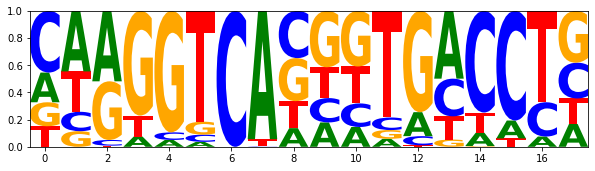

In [ ]:
logomaker.Logo(pd.DataFrame(theta["psi_1"].T, columns=['A', 'C', 'G', 'T']))

# Compare $\psi_{k,p}^{(1)}$ for diffrent initializations

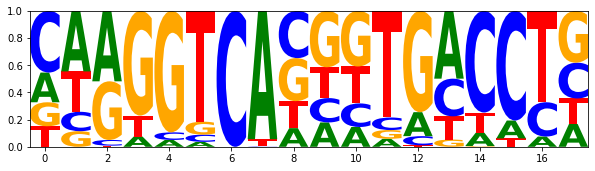

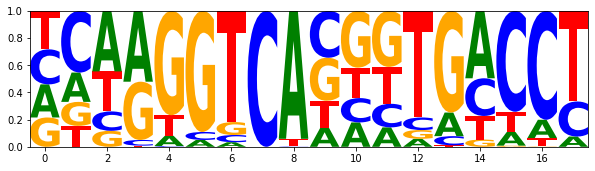

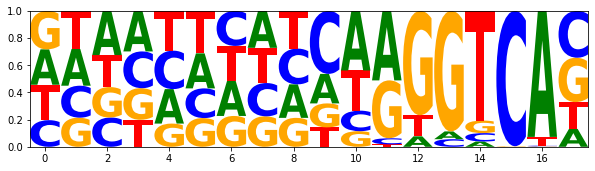

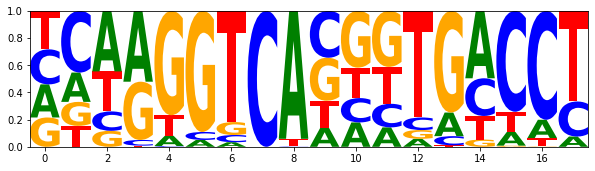

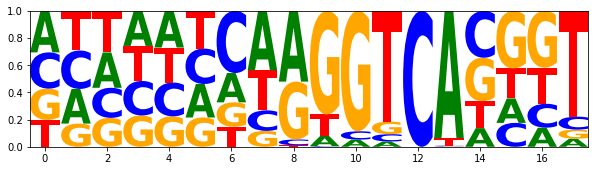

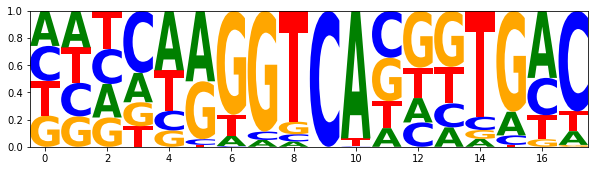

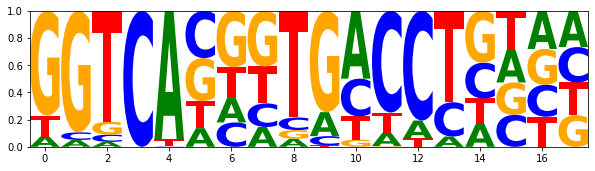

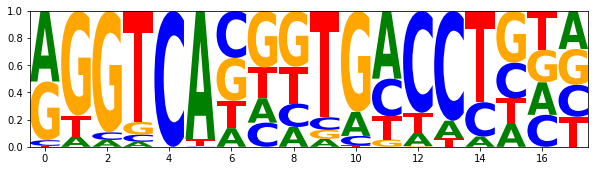

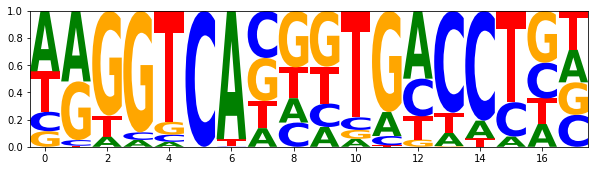

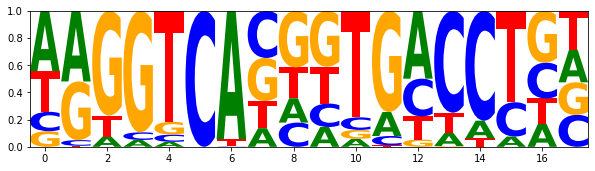

In [ ]:
for iter in result_list:
  logomaker.Logo(pd.DataFrame(iter[0]["psi_1"].T, columns=['A', 'C', 'G', 'T']))

We notice that the fitted $\psi^{(1)}_{k,p}$ differs for different initializations. But there is considerable overlap between many of them.

In [ ]:
[r[2][-1] for r in result_list] # final loglikelihood from different initializations

[-183198.60081663978,
 -183261.8895018651,
 -184538.58635464968,
 -183261.8895018651,
 -184109.36103388626,
 -183630.8354917751,
 -183357.21547712435,
 -183249.7663413064,
 -183262.78749803803,
 -183262.78461628762]

Different initialization also gives different final-step likelihood. That is because the negative likelihood is not convex and has many local minima. Those fitted models with larger likelihood values usually show stronger signals in the foreground motif. Or equivalently, less uncertainty.

# Visualization of $\mathbb{E}_q[C]$

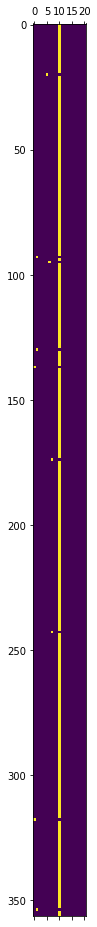

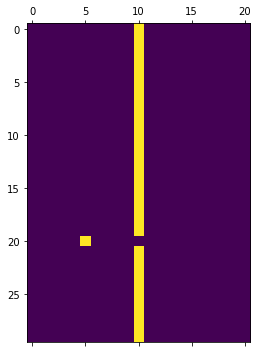

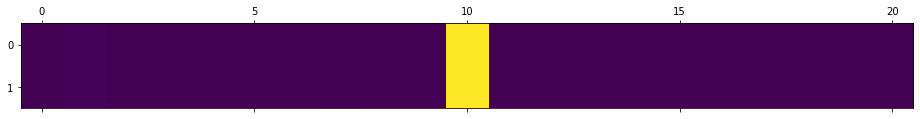

In [ ]:
plt.matshow(EqC) # posterior of C_ij of the entire data set
plt.matshow(EqC[:30]) # first 30 sequences
plt.matshow(np.array([EqC.mean(axis=0)]*2)) # averaged over the entire data set

## Compare with the multinomial parameter $\lambda$.

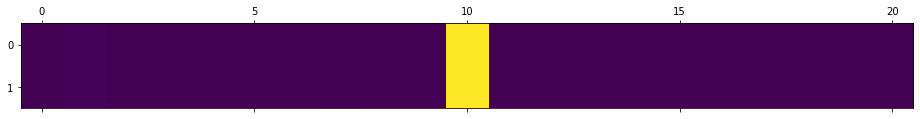

In [ ]:
plt.matshow(np.array([theta['lmbda']]*2))

In [ ]:
np.argmax(EqC.mean(axis=0))

10

We see that for all but a few sequences, the predicted position $C_{ij}$ is the 10th position.

In [ ]:
print((np.apply_along_axis(np.argmax, 1, EqC) != np.argmax(EqC.mean(axis=0))).sum())
print((np.apply_along_axis(np.argmax, 1, EqC) != np.argmax(EqC.mean(axis=0))).mean())

9
0.025210084033613446


Only 9 out of 357 sequences (2.5%) are predicted to have position other than 10.

Let's compare the predicted positions with the truth.

In [ ]:
CC_sequences_padded = pd.read_csv(io.StringIO(requests.get('https://ucdavis.box.com/shared/static/gd0r12mdkhix86bo9ffbn3dy0fy0prmn.txt').text), sep=",", header=None).to_numpy()

In [ ]:
(np.argmax(CC_sequences_padded,axis=1) == np.apply_along_axis(np.argmax, 1, EqC)).mean()

0.9971988795518207

We reach an accuracy of 99.7%.

# Test set performance

In [ ]:
np.random.seed(0)
shuffled_index = np.random.choice(range(N), size=N, replace=False)
n_train = round(N * 0.8)
train_index = shuffled_index[:n_train]
test_index = shuffled_index[n_train:]

X_train, X_test = XXss_sequences_padded[train_index], XXss_sequences_padded[test_index]

In [ ]:
X_train.shape, X_test.shape

((286, 38, 4), (71, 38, 4))

In [ ]:
theta_train, EqC_train, record_loglik_train = run_EM(init_EM(20), X_train)

 45%|████▌     | 9/20 [00:02<00:03,  3.07it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in multiply
 65%|██████▌   | 13/20 [00:04<00:02,  3.26it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in multiply
100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


In [ ]:
record_loglik_train[-1]

-146685.59383614795

In [ ]:
EqC_test = E_step(theta_train, X_test)
#plt.matshow(EqC_test)
print('held-out likelihood by current model:', loglikelihood(X_test, theta_train, EqC_test))
print('average train set loss by current model:', -1/X_train.shape[0]* record_loglik_train[-1])
print('average test set loss by current model:', -1/X_test.shape[0]*loglikelihood(X_test, theta_train, EqC_test))

held-out likelihood by current model: -37001.9101849813
average train set loss by current model: 512.8866917347831
average test set loss by current model: 521.1536645772014


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in multiply


## Compare with the simple latent model

In [ ]:
def init_EM_simple(NUM_MODELS):
  lmbda = np.random.uniform(0, 1,size=(NUM_MODELS,))
  lmbda = lmbda/np.sum(lmbda)
  psi = np.random.uniform(0,1,size=(4,NUM_MODELS))
  psi = psi/psi.sum(axis=0)
  theta = {'lmbda': lmbda, 'psi': psi}
  return(theta)

#----------------------------------------
# compute posteriors P(C_ij | X_ij, theta)
# return a 4 x NUM_MODELS object PP, where PP[aa,bb] = P(C_ij = bb | X_ij = aa, theta)
def E_step_simple(theta):
  unnormalized_posteriors = theta['psi']*theta['lmbda']
  normalized_posteriors = (unnormalized_posteriors.T/unnormalized_posteriors.sum(axis=1)).T
  return(normalized_posteriors)

#----------------------------------------
# compute MLE of psi, lambda
# theta: current parameter set used to calculate posteriors
# XXss: summary statistics of # of bases across all training sequences
# return a dictionary containing psi, lambda
def M_step_simple(XXss, posteriors):
  unnormalized_psi = (posteriors.T*XXss).T
  unnormalized_lambda = unnormalized_psi.sum(axis=0)
  psi = unnormalized_psi/unnormalized_psi.sum(axis=0)
  lmbda = unnormalized_lambda/np.sum(unnormalized_lambda)
  return({'lmbda': lmbda, 'psi': psi})

#----------------------------------------
# compute log likelihood, given posteriors based off the current parameter set theta (so KL = 0)
def loglikelihood_simple(XXss, theta, posteriors):
  #matrix JP of weighted joint log probabilities, size 4xNUM_MODELS, where JP[aa,bb] = E[Cij=bb] log P(Xij = aa, Cij = bb | theta) 
  weighted_log_joint_prob = (np.log(theta['psi'])+np.log(theta['lmbda']))*posteriors  
  weighted_log_joint_prob[np.where(posteriors == 0)]=0; #putting in a check in case some posteriors are 0 (because some psi are 0) - 0log0 = 0 (otherwise we will get nan)
  
  expected_complete_LL = np.sum(weighted_log_joint_prob.T*XXss)
  #entropy term calculation needs to be careful since 0log0 = 0, but coded naively will give nan
  qlogq = posteriors * np.log(posteriors);
  qlogq[np.where(posteriors == 0)] = 0 #0log0 = 0
  return (expected_complete_LL - np.sum(np.sum(qlogq,axis=1) * XXss)) #log likelihood = ELBO + entropy, when q=p

In [ ]:
X_ss_train = np.zeros((1, 4))
X_ss_test = np.zeros((1, 4))
for ii in range(4):
  X_ss_train[0,ii] = np.sum(X_train[:,:,ii])
  X_ss_test[0,ii] = np.sum(X_test[:,:,ii])

In [ ]:
theta_simple = init_EM_simple(NUM_MODELS = 2)

for ii in range(10):  
  posteriors = E_step_simple(theta_simple);  
  print(loglikelihood_simple(X_ss_train, theta_simple, posteriors))
  theta_simple = M_step_simple(X_ss_train, posteriors);

#evaluate on held-out test data
posteriors = E_step_simple(theta_simple)
print('held-out likelihood by simple latent model:', loglikelihood_simple(X_ss_test, theta_simple, posteriors))
print('average train set loss by simple latent model:', -1/X_train.shape[0]*loglikelihood_simple(X_ss_train, theta_simple, posteriors))
print('average test set loss by simple latent model:', -1/X_test.shape[0]*loglikelihood_simple(X_ss_test, theta_simple, posteriors))

-15464.318817884025
-15060.549969493468
-15060.549969493468
-15060.549969493466
-15060.549969493468
-15060.549969493466
-15060.549969493468
-15060.549969493466
-15060.549969493466
-15060.549969493466
held-out likelihood by simple latent model: -3741.0797270980884
average train set loss by simple latent model: 52.65926562759953
average test set loss by simple latent model: 52.69126376194491


Conclusion:

held-out likelihood by simple latent model: -3741.0797270980884

held-out likelihood by our new model: -37001.9101849813

Despite the fact that our new model seems a better fit of the data, the simple latent model gives higher likelihood of the held-out set.

# Train on the `atgcsequences.txt` sequence

## Train on the new model

In [ ]:
XXss_at_gc, XX_sequences_padded = get_sequence('https://ucdavis.box.com/shared/static/s8g6zx9vwxbbfdxdj2uqzhlvslc1jhsy.txt')

100%|██████████| 1/1 [00:00<00:00, 888.25it/s]


The single sequence is ATTTAATATAAAATTTGGCCGCCATAAAAAAA

In [ ]:
XXss_at_gc.shape

(1, 32, 4)

In [ ]:
theta_atgc = init_EM(0,L=XXss_at_gc.shape[1], P=18)

In [ ]:
theta_atgc, EqC_atgc, loglik_atgc = run_EM(theta_atgc ,X=XXss_at_gc, L=XXss_at_gc.shape[1], P=18, n_iter=1)

100%|██████████| 1/1 [00:00<00:00, 345.92it/s]


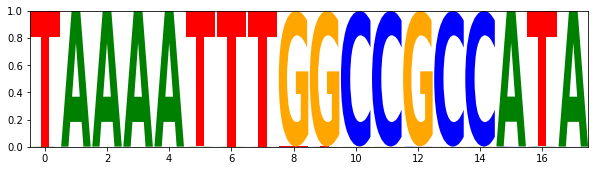

In [ ]:
logomaker.Logo(pd.DataFrame(theta_atgc["psi_1"].T, columns=['A', 'C', 'G', 'T']))

This is the motif it learned. It is just a random piece of the sequence. Because there is only one sequence in the data, we could not expect the motif to be identified.

In [ ]:
loglik_atgc

[-437.3748418459958]

## Train on the simple latent model

In [ ]:
X_atgc_ss = np.zeros((1, 4))
for ii in range(4):
  X_atgc_ss[0,ii] = np.sum(XXss_at_gc[:,:,ii])

In [ ]:
np.random.seed(16)
theta_atgc_simple = init_EM_simple(NUM_MODELS = 2)

for ii in range(5):  
  posteriors = E_step_simple(theta_atgc_simple);  
  print(loglikelihood_simple(X_atgc_ss, theta_atgc_simple, posteriors))
  theta_atgc_simple = M_step_simple(X_atgc_ss, posteriors);

#evaluate on held-out test data
posteriors = E_step_simple(theta_atgc_simple)
print('log likelihood by simple latent model:', loglikelihood_simple(X_atgc_ss, theta_atgc_simple, posteriors))

-51.66460052133196
-37.926093827244884
-37.926093827244884
-37.926093827244884
-37.926093827244884
log likelihood by simple latent model: -37.926093827244884


In [ ]:
theta_atgc_simple

{'lmbda': array([0.51286519, 0.48713481]),
 'psi': array([[0.78878088, 0.19596575],
        [0.08823343, 0.16370857],
        [0.1089718 , 0.07772419],
        [0.01401388, 0.56260149]])}

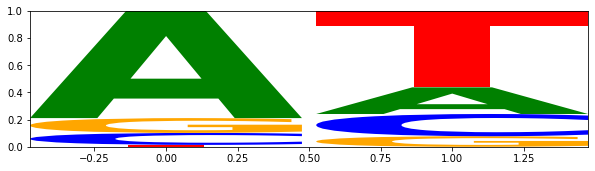

In [ ]:
logomaker.Logo(pd.DataFrame(theta_atgc_simple["psi"].T, columns=['A', 'C', 'G', 'T']))

Here shows the two columns of fitted $\widehat{\psi}$ in the simple latent model.  One for $\widehat{\psi}_0$, and the other for $\widehat{\psi}_1$. We see the first one has a large probability of A, and the second one has a high probability of T

## Compare training ELBO of these two models

Conclusion:

ELBO by simple latent model: -37.926093827244884

ELBO by our new model: -437.3748418459958

The simple latent model gives higher likelihood than the new model. This is expected because the single-sequence data is better modeled by the simple latent model.

# Training with Random Noise

In [ ]:
def Random_Data_X(N=N, L=L, seed=0):
  np.random.seed(seed)
  return np.eye(4)[np.random.choice(4, N*L)].reshape((N,L,4))

## Add 357 random noise samples

In [ ]:
X_noise = Random_Data_X()

In [ ]:
X_full = np.concatenate((X_noise, XXss_sequences_padded))

In [ ]:
X_full.shape

(714, 38, 4)

In [ ]:
theta_augmented, EqC_augmented, record_loglik_augmented = run_EM(init_EM(20), X_full)

100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


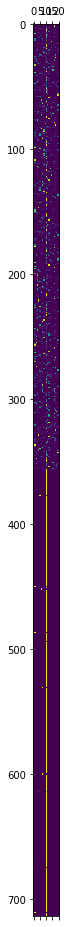

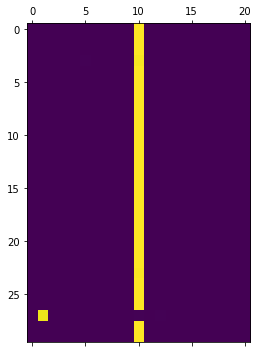

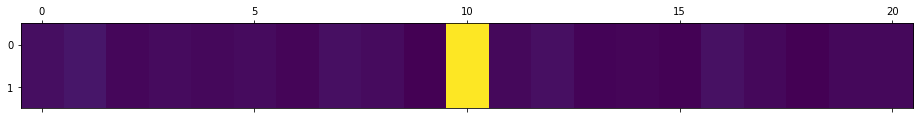

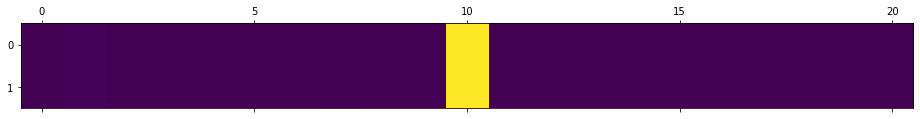

In [ ]:
plt.matshow(EqC_augmented)
plt.matshow(EqC_augmented[-30:]) # first 30 sequences
plt.matshow(np.array([EqC_augmented.mean(axis=0)]*2)) # Posterior of C_ij averaged over the entire data set
plt.matshow(np.array([theta['lmbda']]*2)) # estimated lambda

The model is still able to find position 10 as the starting point of the motif.

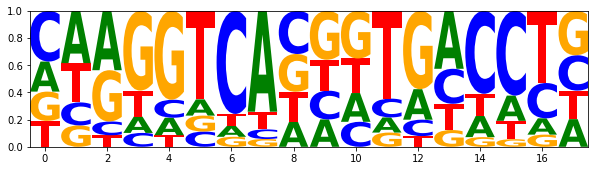

In [ ]:
logomaker.Logo(pd.DataFrame(theta_augmented["psi_1"].T, columns=['A', 'C', 'G', 'T']))

Let's compare with the motif found in the real training data.

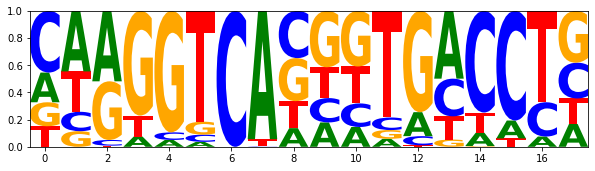

In [ ]:
logomaker.Logo(pd.DataFrame(theta["psi_1"].T, columns=['A', 'C', 'G', 'T']))

The model is still able to find the same motif.

## Add 3000 random noise samples

In [ ]:
X_noise = Random_Data_X(N=3000)

In [ ]:
X_full = np.concatenate((X_noise, XXss_sequences_padded))
X_full.shape

(3357, 38, 4)

In [ ]:
theta_augmented, EqC_augmented, record_loglik_augmented = run_EM(init_EM(20), X_full, n_iter=50)

100%|██████████| 50/50 [02:55<00:00,  3.50s/it]


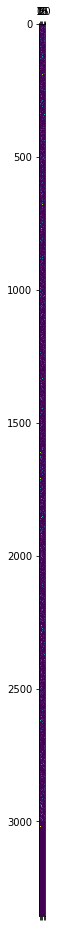

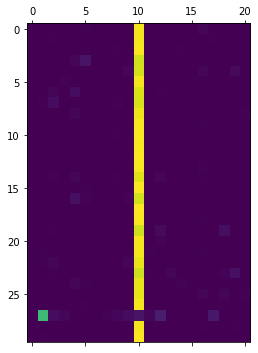

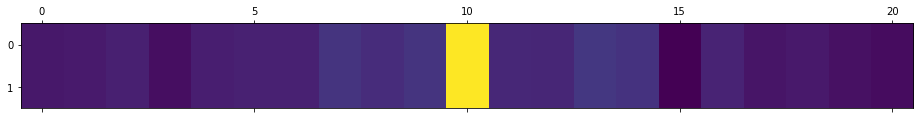

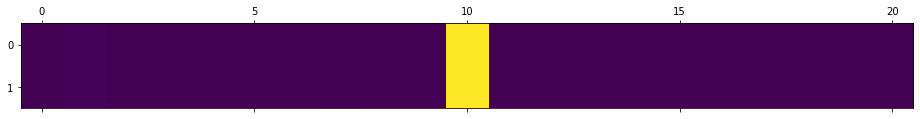

In [ ]:
plt.matshow(EqC_augmented)
plt.matshow(EqC_augmented[-30:]) # first 30 sequences
plt.matshow(np.array([EqC_augmented.mean(axis=0)]*2)) # Posterior of C_ij averaged over the entire data set
plt.matshow(np.array([theta['lmbda']]*2)) # estimated lambda

The model is still able to find position 10 as the starting point of the motif.

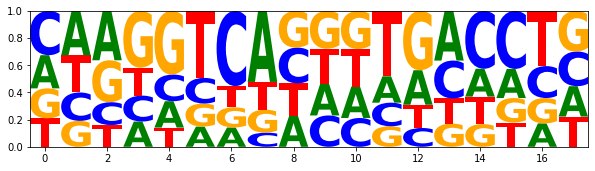

In [ ]:
logomaker.Logo(pd.DataFrame(theta_augmented["psi_1"].T, columns=['A', 'C', 'G', 'T']))

The model is still able to find the same motif, although the signal in the foreground parameter $\widehat{\psi}_1$ is not as strong as training from the original real data. 